# Second step in pipeline

In [86]:
import os
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib.pyplot import figure
%matplotlib inline

## Implement modified TopicTiling Algorithm (Riedl, Biemann, 2012) adjusted for HDBSCAN topic probaiblity vectors

In [179]:
# Functions for segmentation. Segmentation main call function calls all of the above. 

def smoothing(topic_proba_df, threshold):
    """Take the df and output new df with smoothed_topic_probs column 
        threshold (float): all probabilities under the thresold will be set to 0.    
    """
    smoothed_topic_proabilities_ls = []

    for i in range(len(topic_proba_df)):
        smoothed_topic_proabilities = np.array(topic_proba_df.topic_probs[i])
        smoothed_topic_proabilities[smoothed_topic_proabilities < threshold] = 0
        smoothed_topic_proabilities_ls.append(smoothed_topic_proabilities)
    topic_proba_df['smoothed_topic_probabilities'] = smoothed_topic_proabilities_ls

    return topic_proba_df


def window_cosine_sim(dataframe, window_size=3):
    """
    Compute the cosine similarities between consecutive window blocks in a given dataframe.

    Args:
        dataframe (pandas.DataFrame): A dataframe containing topic probabilities.
        window_size (int, optional): The size of the window to use for cosine similarity computation. Defaults to 3.

    Returns:
        numpy.ndarray: An array of cosine similarities between consecutive window blocks.
    """
    transcript_cosine_similarities = []

    for p in range(window_size, len(dataframe)-window_size):
        w_l = dataframe.smoothed_topic_probabilities[p-window_size:p]
        w_r = dataframe.smoothed_topic_probabilities[p:p+window_size]

        # Add probability vectors in blocks
        w_l_added = np.add.reduce(w_l)
        w_r_added = np.add.reduce(w_r)

        # Compute cosine similarity between summed vecors of the windows
        transcript_cosine_similarities.append(np.dot(w_l_added, w_r_added)/(np.linalg.norm(w_l_added) * np.linalg.norm(w_r_added)))
        
    return np.array(transcript_cosine_similarities)


def find_minimas(window_cosines, window_size, print_state, height_param):
    """
    Find the minimas in the cosine similarity values.

    Args:
        window_cosines (numpy.ndarray): An array of cosine similarities between consecutive window blocks.
        window_size (int): The size of the window used for cosine similarity computation.
        print_state (bool): print information about candidate boundaries.
        height_param (float, optional): The minimum height for a peak to be considered a minima. Defaults to -0.995.

    Returns:
        numpy.ndarray: An array containing the indices of the identified minimas.
    """
    window_cosines_neg = window_cosines*-1
    # Find index of minimas, distance = 3 since the smallest segment in our annotations is 3 sentences
    minimas, _ = find_peaks(window_cosines_neg, distance=3, width=2, height=height_param*-1)
    if print_state == 1:
        for position in minimas:
            print(f"Candidate boundary at sent. {position+window_size}, p:{position}, value (cos sim): {window_cosines[position]:.4f}")
    
    return minimas


def hl(p, cos_sims):
    """
    Compute the maximum value of the cosine similarities to the left of the given position.

    Args:
        p (int): The position in the cosine similarities array.
        cos_sims (numpy.ndarray): An array of cosine similarities.

    Returns:
        float: The maximum value of the cosine similarities to the left of the given position.
    """
    max_val = cos_sims[p]
    side_check_range = 3
    for i in range(p-1, 0, -1):
        try: # handle control flow for the first 10 values in cos_sims
            max_found_in_slice = cos_sims[i-side_check_range: i].max()
            if max_found_in_slice >= max_val:
                max_val = max_found_in_slice
                continue
            else:
                break
        except:
            break
    return max_val


def hr(p, cos_sims):
    """
    Compute the maximum value of the cosine similarities to the right of the given position.

    Args:
        p (int): The position in the cosine similarities array.
        cos_sims (numpy.ndarray): An array of cosine similarities.

    Returns:
        float: The maximum value of the cosine similarities to the right of the given position
    """
    max_val = cos_sims[p]
    side_check_range = 3
    for i in range(p+1, len(cos_sims)):
        try: # handle control flow for the last 10 values in cos_sims
            max_found_in_slice = cos_sims[i: i+side_check_range].max()
            if max_found_in_slice >= max_val:
                max_val = max_found_in_slice
                continue
            else:
                break
        except:
              break
    
    return max_val


def depth_scores(cos_sims, minimas):
    """
    Calculate the depth scores for each minima in the cosine similarities.
    Args:
    cos_sims (numpy.ndarray): An array of cosine similarities.
    minimas (numpy.ndarray): An array containing the indices of the identified minimas.

    Returns:
    list: A list of depth scores for each minima.
    """
    scores = []
    for p in minimas:
        dp = 0.5 * (hl(p, cos_sims) + hr(p, cos_sims) - cos_sims[p]*2)
        scores.append(dp)
    return scores


def segment_boundaries(depth_scores, minimas_list, window_size, print_state):
    """
    Determine the segment boundaries based on depth scores and a threshold value.
    Args:
    depth_scores (list): A list of depth scores for each minima.
    minimas_list (numpy.ndarray): An array containing the indices of the identified minimas.
    window_size (int): The size of the window used for cosine similarity computation.
    print_state (bool): print information about segment boundaries.


    Returns:
    list: A list of segment boundaries.
    """
    threshold = np.mean(depth_scores) - (np.std(depth_scores)/2)
    boundaries = []
    for index, score in enumerate(depth_scores):
        if score >= threshold:
            boundaries.append(minimas_list[index] + window_size)
            if print_state == 1:
                print(f"Boundary at sentence {minimas_list[index] + window_size}, p:{minimas_list[index]}, depth score: {score:.4f}")
    return boundaries


def plot_cosine_scores(cosine_similarities_for_windows, window_size, boundaries=None):
    """
    Plot the cosine similarities and negative cosine similarities over transcript windows.

    Args:
    cosine_similarities_for_windows (numpy.ndarray): An array of cosine similarities between consecutive window blocks.
    window_size (int): window sice of segmenter algorithm. Used in title.
    boundaries (list, optional): List of int:s containing placements of segment boundaries. 
    """
    plt.style.use(['science','no-latex'])
    plt.figure(figsize=(6, 4.5))
    
    ax = sns.lineplot(cosine_similarities_for_windows)
    ax.set_ylim(bottom=0, top=1)
    ax.set_xlim(left=0, right=len(cosine_similarities_for_windows))
    ax.set_xlabel("p\npredicted segment breaks marked in red")
    ax.set_ylabel("Cosine similarity")
    if boundaries != None:
        boundaries_np = np.array(boundaries) - window_size
        ax = sns.scatterplot(x=boundaries_np, y=cosine_similarities_for_windows[boundaries_np], marker="x", linewidth=2, color='r')

    ax.set_title(f"Cos. Sim. Over Transcript Windows [win. size: {window_size}]")
    plt.show()


def segmentation_main_call(dataframe, print_state_min, print_state_depth, height=0.995, window=3, smooting_threshold=1e-20):
    """
    Perform text segmentation by finding segment boundaries based on cosine similarity values.

    Args:
    dataframe (pandas.DataFrame): A dataframe containing topic probabilities.
    print_state_min (bool): print information about candidate boundaries.
    print_state_depth (bool): print information about segment boundaries.
    window_size (int, optional): The size of the window to use for cosine similarity computation. Defaults to 3.

    Returns:
    list: A list of segment boundaries.
    """
    smoothed_probability_df = smoothing(dataframe, smooting_threshold)
    window_cosines = window_cosine_sim(smoothed_probability_df, window_size=window)
    min = find_minimas(window_cosines, print_state=print_state_min, window_size=window, height_param=height)
    ds = depth_scores(window_cosines, min)
    bounds = segment_boundaries(ds, min, window_size=window, print_state=print_state_depth)
    return bounds


def close_match(actual_breaks, predicted_breaks, close_definition=3): 
    """
    Find close matches between actual and predicted breaks. Returns accuracy, actual number of close matches and the positions of the close matches.
    actual_breaks: set of actual breaks
    predicted_breaks: set of predicted breaks
    close_definition: int, how many sentences a segment break can be away from the actual break to count as close. 
    """
    s = predicted_breaks.copy()
    new_set = set()
    for element in s:
        for i in range(1, close_definition+1): 
            new_set.add(element-i)
            new_set.add(element+i)
    s.update(new_set)

    intersection_actual_pred = actual_breaks.intersection(s)
    return (len(intersection_actual_pred)/len(actual_breaks)), len(intersection_actual_pred), intersection_actual_pred

## Pipeline step 2

In [ ]:
# Try out different hyperparameter settings and get KPIs for all 20 annotated transcripts
actual = pd.read_pickle('annotations.pkl')

# walk directory to loop through files
for dirpath, _, files in os.walk('../Thesis/annotated_probabilities_msize200'):
    
    # initialise lists for appending scores
    episode = []; actual_breaks = []; predicted_breaks = []; exact_matches = []
    close_matches = []; accuracy = []; window_param = []; height_param = []; len_of_transcript = []; window_diff_ls = []

    # For each file, get KPIs for different hyperparameter settings and add to lists
    for file in files:
        eps_id = file[:-4].split('_')[4]
        path = os.path.join(dirpath, file)
        topic_proba_dens_vector = np.load(path)
        vector_length = len(topic_proba_dens_vector)
        annotated_probabilities_df = pd.DataFrame({"sentence_no":[i for i in range(vector_length)],
                                                    "topic_probs": topic_proba_dens_vector.tolist()})

        # get predicted bounds
        # he = [0.99, 0.95, 0.9]
        # for h in he:
        h=0.95
        for win in range(2, 41, 2):
            if win*2 >= len(annotated_probabilities_df.index):
                print(win)
                break
            else:
                predicted_bounds = segmentation_main_call(annotated_probabilities_df,\
                                                            print_state_min=False,\
                                                            print_state_depth=False,\
                                                            window=win, height=0.95)
                predicted_bounds_set = set(predicted_bounds)

                # get actual bounds
                actual_bounds = actual[actual.episode_id == eps_id].iloc[0,2]

                # get exact and close matches
                actual_bounds_set = set(actual_bounds)
                
                acc, num_matches, list = close_match(actual_bounds_set, predicted_bounds_set, close_definition=5)
                
                # Append to build dataframe downstream
                episode.append(eps_id)
                actual_breaks.append(len(actual_bounds_set))
                predicted_breaks.append(len(predicted_bounds))
                exact_matches.append(len(predicted_bounds_set.intersection(actual_bounds_set)))
                close_matches.append(num_matches)
                accuracy.append(acc)
                window_param.append(win)
                height_param.append(h)
                len_of_transcript.append(vector_length)

                # window diff, k = window size
                k = 4
                window_diff_unnormalised = 0
                for i in range(vector_length - k):
                    sliding_window = set([w for w in range(i, i + k, 1)])
                    actual_in_sliding_window = len(actual_bounds_set.intersection(sliding_window)) # ref
                    predicted_in_sliding_window = len(predicted_bounds_set.intersection(sliding_window)) # hyp
                    window_diff_absolute = (np.abs(actual_in_sliding_window - predicted_in_sliding_window)) #  / k
                    window_diff_unnormalised += window_diff_absolute
                window_diff = (1/(vector_length-k)) * window_diff_unnormalised
                window_diff_ls.append(window_diff)
        print(eps_id, 'done')

        
    # Create dataframe with all figures for comparison
    evaluation_df = pd.DataFrame({'episode': episode,
                                  'actual_breaks': actual_breaks,
                                  'predicted_breaks': predicted_breaks,
                                  'exact_matches': exact_matches,
                                  'close_matches': close_matches,
                                  'window_diff': window_diff_ls,
                                  'accuracy_close_match': accuracy,
                                  'window_size': window_param,
                                  'height': height_param,
                                  'len_of_transcript': len_of_transcript})

print(evaluation_df.shape)

In [166]:
evaluation_df.to_csv('../Thesis/evaluation/evaluation_200.csv')

In [ ]:
# TP: close_matches
# FP: predicted breaks - close matches
# FN: actual breaks - close matches
# TN: transcript_len - predicted breaks - actual breaks + close matches

# evaluation_df['true_positives'] = evaluation_df.close_matches
# evaluation_df['false_positives'] = evaluation_df.predicted_breaks - evaluation_df.close_matches
# evaluation_df['false_negatives'] = evaluation_df.actual_breaks - evaluation_df.close_matches
# evaluation_df['true_negatives'] = evaluation_df.len_of_transcript - evaluation_df.predicted_breaks - evaluation_df.actual_breaks + evaluation_df.close_matches
# evaluation_df['precision'] = evaluation_df.true_positives/(evaluation_df.true_positives + evaluation_df.false_positives)
# evaluation_df['recall'] = evaluation_df.true_positives/(evaluation_df.true_positives + evaluation_df.false_negatives)
# evaluation_df['F1'] = evaluation_df.true_positives / (evaluation_df.true_positives + 0.5*(evaluation_df.false_positives + evaluation_df.false_negatives))
evaluation_df.loc[0:50]
# evaluation_df.episode.unique()

# after

### Visualise results

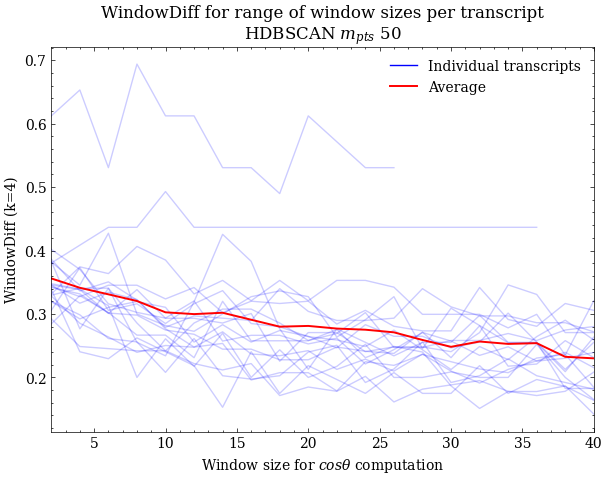

In [165]:
# Plot evaluation metric over different k for each annotated transcript
grouped_df = evaluation_df.groupby('window_size')[['window_diff']].mean()  # get average

figure(figsize=(7, 5))
palette = sns.color_palette(['blue'], 20)
ax1 = sns.lineplot(evaluation_df, x='window_size', y='window_diff', hue='episode', palette=palette, alpha=0.2)
ax2 = sns.lineplot(data = grouped_df, x='window_size', y='window_diff', color='red', alpha=1, label='Average', linewidth=1.4)
current_handles, current_labels = plt.gca().get_legend_handles_labels()  # get legend obejcts 
plt.legend(current_handles[-2:], ['Individual transcripts','Average'])  # modify legend
plt.xlim(min(evaluation_df.window_size), max(evaluation_df.window_size))
# plt.ylim(0.03, 0.19)
plt.ylabel('WindowDiff (k=4)')
plt.xlabel(r'Window size for $cos \theta$ computation')
plt.title('WindowDiff for range of window sizes per transcript\nHDBSCAN $m_{pts}$ 50')
plt.show()

In [167]:
# DFs for plot below
eval15 = pd.read_csv('../Thesis/evaluation/evaluation_15.csv')
eval50 = pd.read_csv('../Thesis/evaluation/evaluation_50.csv')
eval200 = pd.read_csv('../Thesis/evaluation/evaluation_200.csv')

grouped_15 = eval15.groupby('window_size')[['window_diff']].mean()  # get average
grouped_50 = eval50.groupby('window_size')[['window_diff']].mean()  # get average
grouped_200 = eval200.groupby('window_size')[['window_diff']].mean()  # get average

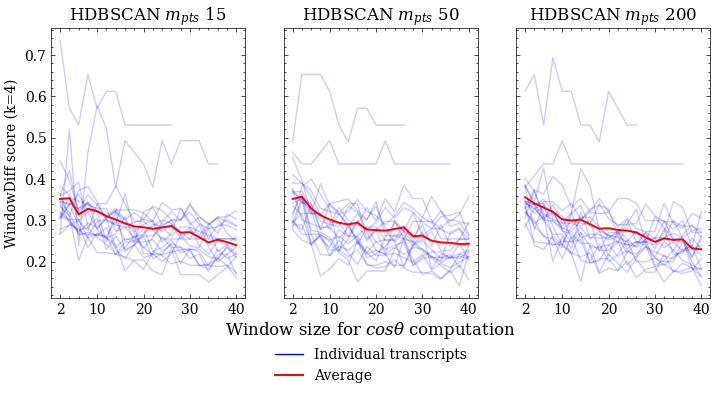

In [168]:
# Plot evaluation metric over different windowsize for each annotated transcript
fig, axs = plt.subplots(1,3, figsize=(8.5, 3.5), sharey=True)
palette = sns.color_palette(['blue'], 20)

ax1 = sns.lineplot(data=eval15, x='window_size', y='window_diff', hue='episode', palette=palette, alpha=0.2, ax=axs[0])
ax2 = sns.lineplot(data = grouped_15, x='window_size', y='window_diff', color='red', alpha=1, label='Average', linewidth=1.4, ax=axs[0])
ax3 = sns.lineplot(data=eval50, x='window_size', y='window_diff', hue='episode', palette=palette, alpha=0.2, ax=axs[1])
ax4 = sns.lineplot(data = grouped_50, x='window_size', y='window_diff', color='red', alpha=1, label='Average', linewidth=1.4, ax=axs[1])
ax5 = sns.lineplot(data=eval200, x='window_size', y='window_diff', hue='episode', palette=palette, alpha=0.2, ax=axs[2])
ax6 = sns.lineplot(data = grouped_200, x='window_size', y='window_diff', color='red', alpha=1, label='Average', linewidth=1.4, ax=axs[2])

# modify legend
axs[0].get_legend().remove()
axs[2].get_legend().remove()
current_handles, current_labels = plt.gca().get_legend_handles_labels()  
axs[1].legend(current_handles[-2:], ['Individual transcripts','Average'], loc='lower center', bbox_to_anchor=(0.45, -0.36))

axs[0].set_title('HDBSCAN $m_{pts}$ 15')
axs[1].set_title('HDBSCAN $m_{pts}$ 50')
axs[2].set_title('HDBSCAN $m_{pts}$ 200')

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
fig.supxlabel(r'Window size for $cos \theta$ computation', y=-0.012)

axs[0].set_xticks([2,10,20,30,40])
axs[1].set_xticks([2,10,20,30,40])
axs[2].set_xticks([2,10,20,30,40])

axs[0].set_ylabel('WindowDiff score (k=4)')

plt.show()

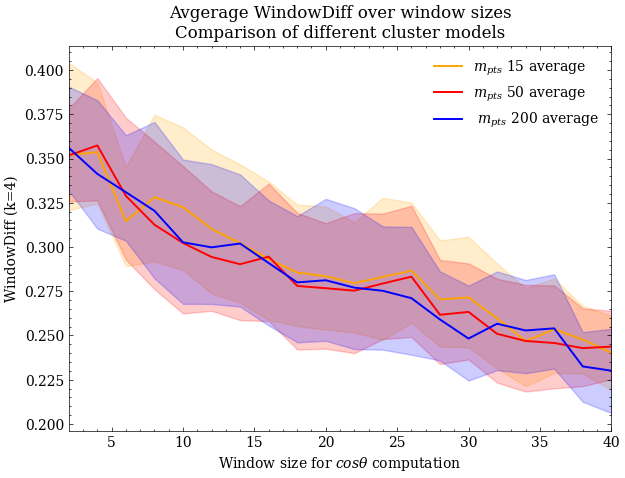

In [169]:
# plot all averages
figure(figsize=(7, 5))

ax1 = sns.lineplot(data = eval15, x='window_size', y='window_diff', color='orange', alpha=1, label='$m_{pts}$ 15 average', linewidth=1.4)
ax2 = sns.lineplot(data = eval50, x='window_size', y='window_diff', color='red', alpha=1, label='$m_{pts}$ 50 average', linewidth=1.4)
ax3 = sns.lineplot(data = eval200, x='window_size', y='window_diff', color='blue', alpha=1, label=' $m_{pts}$ 200 average', linewidth=1.4)

plt.xlim(min(evaluation_df.window_size), max(evaluation_df.window_size))
plt.ylabel('WindowDiff (k=4)')
plt.xlabel(r'Window size for $cos \theta$ computation')
plt.title('Avgerage WindowDiff over window sizes\nComparison of different cluster models')
plt.show()

### Investigate individual transcripts

In [ ]:
# load sentence probabilities from 1 step
# sent_proba = np.load('../Thesis/probabilities.npy')  #../Thesis/probabilities.npy window size 34
sent_proba = np.load('../Thesis/annotated_probabilities_msize200/proba_dens_vec_msize200_0ZGQ63222rqX5TD5ZrMmcN.npy')  #../Thesis/probabilities.npy window size 34
print(sent_proba.shape)

# make dataframe for processing
pipeline_df = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba))], "topic_probs": sent_proba.tolist()})
pipeline_df.head()

(601, 155)


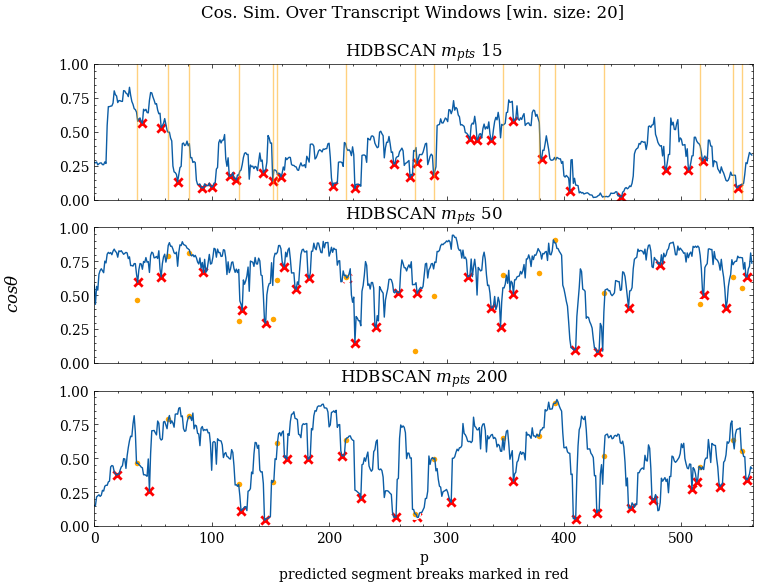

In [237]:
# Analyse same transcript over all cluster models
sent_proba15 = np.load('../Thesis/annotated_probabilities_msize15/proba_dens_vec_msize15_0ZGQ63222rqX5TD5ZrMmcN.npy')
sent_proba50 = np.load('../Thesis/annotated_probabilities_msize50/proba_dens_vec_msiz500ZGQ63222rqX5TD5ZrMmcN.npy')
sent_proba200 = np.load('../Thesis/annotated_probabilities_msize200/proba_dens_vec_msize200_0ZGQ63222rqX5TD5ZrMmcN.npy')
print(sent_proba200.shape)

# make dataframe for processing and get properties
pipeline_df15 = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba15))], "topic_probs": sent_proba15.tolist()})
pipeline_df50 = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba50))], "topic_probs": sent_proba50.tolist()})
pipeline_df200 = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba200))], "topic_probs": sent_proba200.tolist()})

smooth15 = smoothing(pipeline_df15, threshold=1e-20)
smooth50 = smoothing(pipeline_df50, threshold=1e-20)
smooth200 = smoothing(pipeline_df200, threshold=1e-20)

win = 20
cos_sims15 = window_cosine_sim(smooth15, window_size=win)
cos_sims50 = window_cosine_sim(smooth50, window_size=win)
cos_sims200 = window_cosine_sim(smooth200, window_size=win)

bounds15 = segmentation_main_call(pipeline_df15, print_state_min=False, print_state_depth=False, window=win, height=0.95)
boundaries_np15 = np.array(bounds15) - win
bounds50 = segmentation_main_call(pipeline_df50, print_state_min=False, print_state_depth=False, window=win, height=0.95)
boundaries_np50 = np.array(bounds50) - win
bounds200 = segmentation_main_call(pipeline_df200, print_state_min=False, print_state_depth=False, window=win, height=0.95)
boundaries_np200 = np.array(bounds200) - win

# get actual breaks
actual = pd.read_pickle('annotations.pkl')
actual_bounds_for_plotting = actual[actual.episode_id=='0ZGQ63222rqX5TD5ZrMmcN'].iloc[0,2]
actual_bounds_for_plotting_np = np.array(actual_bounds_for_plotting) - win*2  # compensate for position

# plot same transcript over all cluster models
plt.style.use(['science','no-latex'])
fig, axs = plt.subplots(3,1, figsize=(8.5, 6), sharey=True, sharex=True)

sns.lineplot(cos_sims15, ax=axs[0])
sns.lineplot(cos_sims50, ax=axs[1])
sns.lineplot(cos_sims200, ax=axs[2])
sns.scatterplot(x= boundaries_np15, y=cos_sims15[boundaries_np15], marker="x", linewidth=2, color='r', ax=axs[0])
sns.scatterplot(x= boundaries_np50, y=cos_sims50[boundaries_np50], marker="x", linewidth=2, color='r', ax=axs[1])
sns.scatterplot(x= boundaries_np200, y=cos_sims200[boundaries_np200], marker="x", linewidth=2, color='r', ax=axs[2])
for line in actual_bounds_for_plotting_np:
    axs[0].axvline(line, color='orange', alpha=0.5)
# sns.scatterplot(x= actual_bounds_for_plotting_np, y=cos_sims200[actual_bounds_for_plotting_np], marker="o", linewidth=2, color='orange', ax=axs[0])
sns.scatterplot(x= actual_bounds_for_plotting_np, y=cos_sims200[actual_bounds_for_plotting_np], marker="o", linewidth=2, color='orange', ax=axs[1])
sns.scatterplot(x= actual_bounds_for_plotting_np, y=cos_sims200[actual_bounds_for_plotting_np], marker="o", linewidth=2, color='orange', ax=axs[2])

axs[0].set_title('HDBSCAN $m_{pts}$ 15')
axs[1].set_title('HDBSCAN $m_{pts}$ 50')
axs[2].set_title('HDBSCAN $m_{pts}$ 200')

axs[0].set_ylim(bottom=0, top=1)
axs[0].set_xlim(left=0, right=len(cos_sims15))
axs[2].set_xlabel("p\npredicted segment breaks marked in red")
fig.supylabel(r"$cos \theta$")
fig.suptitle(f"Cos. Sim. Over Transcript Windows [win. size: {win}]")

plt.show()

In [235]:
test = pd.read_csv('../Thesis/annotated_transcripts_input/0ZGQ63222rqX5TD5ZrMmcN_data_for_prediction.csv')
test

,Unnamed: 0,episode_id,transcript_subset,sentence_enumerated
0,0,0ZGQ63222rqX5TD5ZrMmcN,This is Iris illustrate Insider.,1
1,1,0ZGQ63222rqX5TD5ZrMmcN,It's Friday August 9th.,2
2,2,0ZGQ63222rqX5TD5ZrMmcN,I'm Tim Priester with Tim omelly and Pete Samson.,3
3,3,0ZGQ63222rqX5TD5ZrMmcN,We were in Culver for Notre Dame's final pract...,4
4,4,0ZGQ63222rqX5TD5ZrMmcN,We had an opportunity to see the quarterbacks ...,5
...,...,...,...,...
596,596,0ZGQ63222rqX5TD5ZrMmcN,Is going to change is going to alter a little ...,597
597,597,0ZGQ63222rqX5TD5ZrMmcN,We'll let you know when that time comes but un...,598
598,598,0ZGQ63222rqX5TD5ZrMmcN,Thanks for joining us.,599
599,599,0ZGQ63222rqX5TD5ZrMmcN,It's time to start planning your trip to Notre...,600


Window size: 20, segments: 20


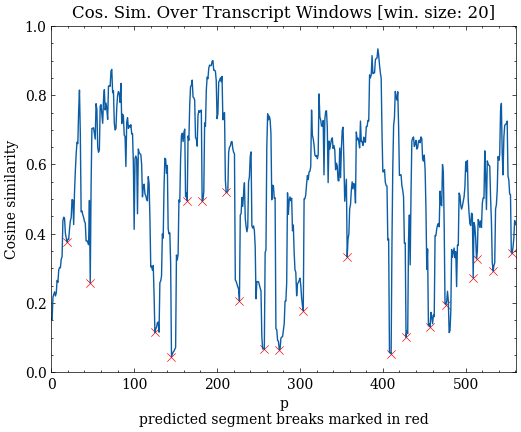

In [186]:
# Plot and analyse with different size windows
sent_proba = np.load('../Thesis/annotated_probabilities_msize200/proba_dens_vec_msize200_0ZGQ63222rqX5TD5ZrMmcN.npy')  #../Thesis/probabilities.npy window size 34
print(sent_proba.shape)

# make dataframe for processing
pipeline_df = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba))], "topic_probs": sent_proba.tolist()})
windows = [i for i in range(20, 21, 2)]

for win in windows:
    bounds = segmentation_main_call(pipeline_df, print_state_min=False, print_state_depth=False, window=win, height=0.95)
    cos_sims = window_cosine_sim(pipeline_df, window_size=win)
    print(f'Window size: {win}, segments: {len(bounds)}')
    plot_cosine_scores(cos_sims, window_size=win, boundaries=bounds)

(601, 555)
Window size: 20, segments: 24


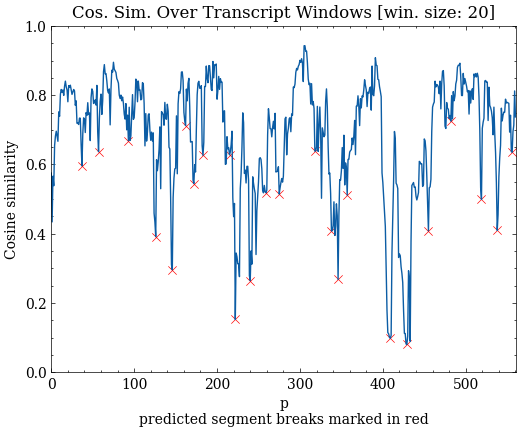

In [191]:
# Plot and analyse with different size windows
sent_proba = np.load('../Thesis/annotated_probabilities_msize50/proba_dens_vec_msiz500ZGQ63222rqX5TD5ZrMmcN.npy')  #../Thesis/probabilities.npy window size 34
print(sent_proba.shape)

# make dataframe for processing
pipeline_df = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba))], "topic_probs": sent_proba.tolist()})
windows = [i for i in range(20, 21, 2)]

for win in windows:
    bounds = segmentation_main_call(pipeline_df, print_state_min=False, print_state_depth=False, window=win, height=0.95)
    cos_sims = window_cosine_sim(pipeline_df, window_size=win)
    print(f'Window size: {win}, segments: {len(bounds)}')
    plot_cosine_scores(cos_sims, window_size=win, boundaries=bounds)

(601, 2880)
Window size: 20, segments: 27


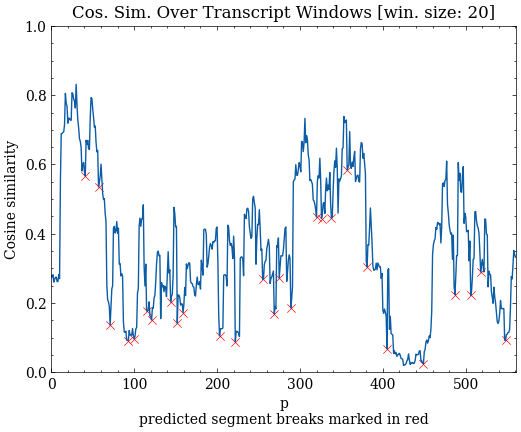

In [188]:
# Plot and analyse with different size windows
sent_proba = np.load('../Thesis/annotated_probabilities_msize15/proba_dens_vec_msize15_0ZGQ63222rqX5TD5ZrMmcN.npy')  #../Thesis/probabilities.npy window size 34
print(sent_proba.shape)

# make dataframe for processing
pipeline_df = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba))], "topic_probs": sent_proba.tolist()})
windows = [i for i in range(20, 21, 2)]

for win in windows:
    bounds = segmentation_main_call(pipeline_df, print_state_min=False, print_state_depth=False, window=win, height=0.95)
    cos_sims = window_cosine_sim(pipeline_df, window_size=win)
    print(f'Window size: {win}, segments: {len(bounds)}')
    plot_cosine_scores(cos_sims, window_size=win, boundaries=bounds)

## Testing with synthetic data

### Generate synthetic data

In [152]:
# Generate synthetic topic probabilities
def generate_topic_probs(num_topics, num_sentences, topic_shift_interval):
    topic_probs = []

    np.random.seed(42)
    for i in range(num_sentences):
        if i % topic_shift_interval == 0:
            current_topic = np.random.dirichlet(np.ones(num_topics))
        
        noise = np.random.uniform(0.01, 0.05, num_topics)
        noisy_current_topic = current_topic + noise
        noisy_current_topic /= np.sum(noisy_current_topic)
        
        topic_probs.append(noisy_current_topic)

    return topic_probs

# Parameters for the synthetic dataset
num_topics = 5
num_sentences = 50
topic_shift_interval = 10

# Create the synthetic dataset
topic_probs = generate_topic_probs(num_topics, num_sentences, topic_shift_interval)

testing_df = pd.DataFrame({"sentence_no":[i for i in range(len(topic_probs))], "topic_probs": topic_probs})
testing_df.head()

,sentence_no,topic_probs
0,0,"[0.08385716116533869, 0.4577269140883433, 0.23..."
1,1,"[0.07960811538795794, 0.4925288864249926, 0.23..."
2,2,"[0.08679586102928998, 0.4772173114150449, 0.22..."
3,3,"[0.10163211228247594, 0.4691453126857391, 0.21..."
4,4,"[0.1067637438686018, 0.466769664868021, 0.2241..."


### Testing

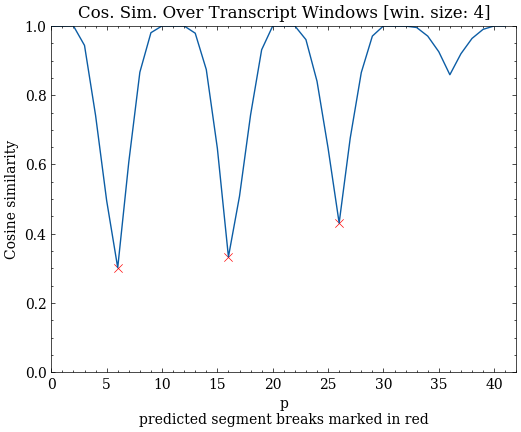

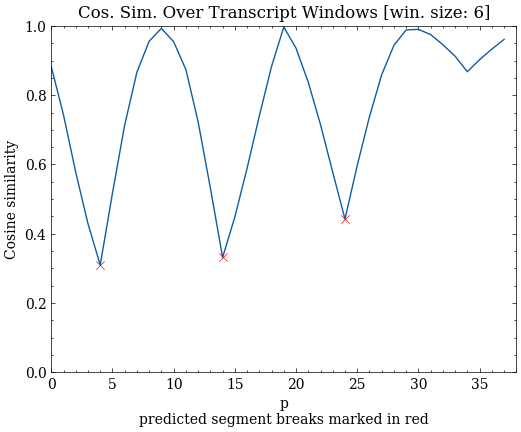

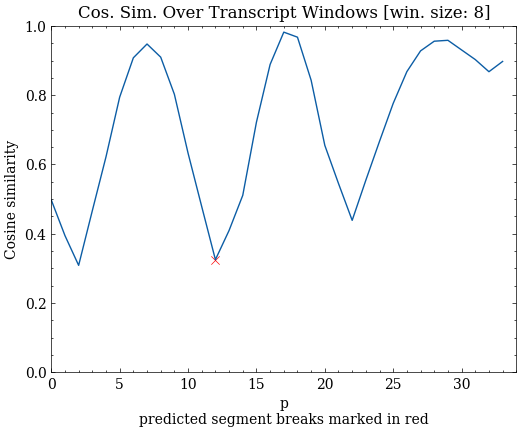

In [154]:
# Evaluate differente window sizes on synthetic data

windows_ls = [i for i in range(4, 9, 2)]

for window in windows_ls:
    bounds_testing = segmentation_main_call(testing_df, print_state_min=False, print_state_depth=False, window=window, height=0.95)
    con_sim = window_cosine_sim(testing_df, window_size = window)
    plot_cosine_scores(con_sim, window_size=window, boundaries=bounds_testing)
    print()